In [1235]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, expect_val, expect_val_dm, steadystate
from torchqc.operators import DynamicOperator, Operator
from torchqc.common_matrices import annihilation, creation
from torchqc.dynamics import libland_equation, TDSE, TDSE_numeric
from torchqc.runge_kutta_methods import runge_kutta45

from random import sample
from qutip import mcsolve, basis, destroy

In [1236]:
N = 5  # number of basis states to consider
kappa = 1.0 / 0.129  # coupling to heat bath
nth = 0.063  # temperature with <n>=0.063

tlist = np.linspace(0, 0.6, 100)

In [1237]:
a = destroy(N)  # cavity destruction operator
H = a.dag() * a  # harmonic oscillator Hamiltonian
psi0 = basis(N, 1)  # initial Fock state with one photon: |1>

# collapse operator list
c_op_list = []

# decay operator
c_op_list.append(np.sqrt(kappa * (1 + nth)) * a)

# excitation operator
c_op_list.append(np.sqrt(kappa * nth) * a.dag())

In [1238]:
ntraj = [100]  # list of number of trajectories to avg. over
mc = []

for n in ntraj:
    result = mcsolve(H, psi0, tlist, c_op_list, e_ops=[a.dag() * a], ntraj=n)
    mc.append(result)

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.23s. Est. time left: 00:00:00:00
50.0%. Run time:   0.29s. Est. time left: 00:00:00:00
60.0%. Run time:   0.35s. Est. time left: 00:00:00:00
70.0%. Run time:   0.41s. Est. time left: 00:00:00:00
80.0%. Run time:   0.46s. Est. time left: 00:00:00:00
90.0%. Run time:   0.52s. Est. time left: 00:00:00:00
100.0%. Run time:   0.57s. Est. time left: 00:00:00:00
Total run time:   0.58s


* Start from basis state $\ket{0}$

In [1239]:
N = 5  # number of basis states to consider
kappa = 1.0 / 0.129  # coupling to heat bath
nth = 0.063  # temperature with <n>=0.063

T = 0.6
Dt = 0.006
time = np.arange(0, T + Dt, Dt, dtype = np.float32)

basis_states = QuantumState.basis(N)
initial_state = basis_states[1]

* Simulate dynamics

In [1240]:
a = annihilation(N)
a_dagger = creation(N)
jump_ops = [a, a_dagger]
rates = [kappa * (1 + nth), kappa * nth]

H = a_dagger * a
hamiltonian = DynamicOperator(N, H, time=time)

In [1241]:
rho = get_density_matrix(initial_state)
_, states = libland_equation(rho, hamiltonian, time, Dt, jump_ops, rates, method='rk45')
libland_exp_val = expect_val_dm(states, a_dagger * a)

In [1242]:
rho_ss = steadystate(H, jump_ops, rates)
N_ss = expect_val_dm(rho_ss, a_dagger * a)

* Simulate dynamics with QMCT

In [1243]:
def QMCT(initial_state: QuantumState, hamiltonian: DynamicOperator, time: np.ndarray, Dt: float, jump_operators: list, damp_rates: list, nb_tranj: int) -> list:
    r"""
    QMCT(initial_state: QuantumState, hamiltonian: Operator, time: np.array, Dt: float, jump_operators: list = [], damp_rates = []) -> list
    
    Returns a list of states as the qunatum system evolves in time
    
    The shapes of the :attr:`initial_state` and the :attr:`hamiltonian` tensor need
    to match.
    
    Args:
        initial_state (QuantumState): the initial quantum state.
        hamiltonian  (Operator): hamiltonian matrix or matrices
        time (np.ndarray): time in discrete time steps
        Dt (float): time step duration
        jump_operators: list[Operator]
            list of jump operators
        damp_rates: list[float]
            list of jump rates
    """

    time_tensor = torch.from_numpy(time).reshape(len(time), 1)
    time_tensor.requires_grad_(True)

    trajectories = []

    # while traj_index < nb_tranj:
    for j in range(nb_tranj):
        current_state = initial_state
        states = [current_state]

        # generate random number r
        norm_lb = torch.rand(1)

        for i in range(len(time_tensor) - 1):
            Ht = hamiltonian.matrix[i]

            # construct effective hamiltonian
            Heff = Ht

            for rate, jump_op in zip(damp_rates, jump_operators):
                Heff += (- 1j / 2) * rate * (jump_op.dagger() * jump_op).matrix
            
            # current_state_tensor = torch.matmul(torch.linalg.matrix_exp(-1j * Heff * Dt), current_state.state_tensor)
            # current_state = QuantumState(N, current_state_tensor)
            
            small_time = time = np.arange(0, 2 * Dt, Dt, dtype = np.float32)
            small_states = TDSE(current_state, DynamicOperator(hamiltonian.dims, Operator(N, Heff), time=small_time), small_time, Dt)

            current_state = small_states[-1]

            # calculate norm
            norm_squared = current_state.norm() ** 2

            # print("Norm squared = ", norm_squared)

            sum = 0
            for rate, jump_op in zip(damp_rates, jump_operators):
                sum += rate * current_state.inner_product((jump_op.dagger() * jump_op).mul(current_state))
                
            dp = Dt * torch.abs(sum)
            
            # when the norm drops the lb, then perform a quantum jump
            if norm_squared < norm_lb:
                # print("Quantum jump")
                # randomly sample one jump operator from list of jump ops based on certain weights

                # weights = np.array([(torch.real(rate * current_state.inner_product((op.dagger() * op).mul(current_state))) / dp)[0][0] for op, rate in zip(jump_operators, damp_rates)])
                # weights_distr = weights / (np.sum(weights))

                # weights = np.array([torch.real(rate * current_state.inner_product((op.dagger() * op).mul(current_state)))[0][0] for op, rate in zip(jump_operators, damp_rates)])
                weights = np.array([rate * torch.abs(current_state.inner_product((op.dagger() * op).mul(current_state)))[0][0] for op, rate in zip(jump_operators, damp_rates)])
                
                # weights_exp = np.exp(weights)
                # weights_distr = weights_exp / weights_exp.sum()
                weights_sum = weights.sum()
                weights_distr = weights / weights_sum

                random_jump_op = np.random.choice(jump_operators, p=weights_distr)

                # apply random jump op to the state and then normalize it
                current_state = (np.sqrt(rate) * random_jump_op).mul(current_state)

                if current_state.norm() > 0:
                    current_state = current_state.normalize()

                # generate new random norm lower bound
                norm_lb = torch.rand(1)
                                    
            states.append(current_state)

        # if initial state is product state
        if initial_state.is_product:
            product_dims = initial_state.product_dims

            for state in states:
                state.is_product = True
                state.product_dims = product_dims

        trajectories.append(states)

    return trajectories

In [1244]:
trajectories = QMCT(initial_state, hamiltonian, time, Dt, jump_ops, rates, 200)

In [1245]:
def get_averages(trajectories, operator: Operator):
    exp_values_sum = torch.zeros(len(trajectories[0]))

    for states in trajectories:
        for i in range(len(states)):
            if states[i].norm() > 0:
                states[i].normalize()

        exp_values = expect_val(states, operator)
        
        exp_values_sum += exp_values

    return exp_values_sum / len(trajectories)

In [1246]:
avaraged_exp_values = get_averages(trajectories, a_dagger * a)

In [1247]:
mc[0].expect[0]

array([1.  , 0.95, 0.92, 0.88, 0.85, 0.83, 0.82, 0.81, 0.77, 0.68, 0.64,
       0.6 , 0.57, 0.55, 0.5 , 0.47, 0.47, 0.44, 0.42, 0.4 , 0.4 , 0.41,
       0.42, 0.4 , 0.38, 0.36, 0.36, 0.36, 0.35, 0.34, 0.3 , 0.31, 0.29,
       0.29, 0.28, 0.28, 0.26, 0.28, 0.28, 0.28, 0.28, 0.28, 0.29, 0.28,
       0.29, 0.27, 0.24, 0.23, 0.21, 0.21, 0.21, 0.22, 0.22, 0.22, 0.22,
       0.2 , 0.16, 0.16, 0.16, 0.16, 0.14, 0.14, 0.15, 0.15, 0.15, 0.16,
       0.16, 0.17, 0.17, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.18, 0.18,
       0.18, 0.18, 0.18, 0.16, 0.17, 0.17, 0.15, 0.14, 0.13, 0.13, 0.13,
       0.13, 0.11, 0.09, 0.09, 0.09, 0.08, 0.08, 0.07, 0.06, 0.06, 0.07,
       0.07])

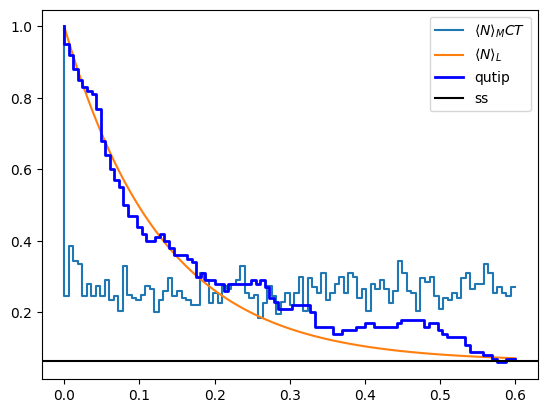

In [1248]:
fig, ax = plt.subplots()

ax.step(time, avaraged_exp_values, label = r"$\langle N \rangle_MCT$")
ax.plot(time, libland_exp_val, label = r"$\langle N \rangle_L$")
ax.step(tlist, mc[0].expect[0], "b", lw=2, label = "qutip")
ax.axhline(y=N_ss, color="k", lw=1.5, label = 'ss')
ax.legend()